In [1]:
# Modules

import constants as const
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import sciann as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

---------------------- SCIANN 0.6.7.7 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.8.1 
Python Version: 3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0] 



In [2]:
# Read reduced dataset

data_turbines = pd.read_csv('../Dataset/Dataset_reduced.csv')
print(data_turbines.shape)

(767248, 5)


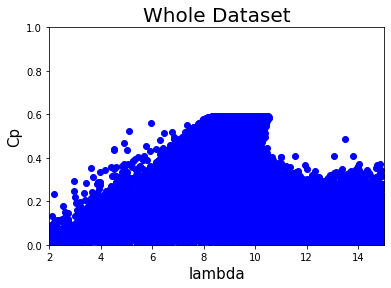

In [3]:
# Normalize data

# Define inputs and outputs
X_data = data_turbines[['V','theta','W']]
Y_data = data_turbines[['T','P']]

X_data = X_data.to_numpy(dtype='float64')
Y_data = Y_data.to_numpy(dtype='float64')

# Cp 
def Cp_fromP(Pturbina, Vw):

    Cp = Pturbina / (0.5 * const.rho * const.A * Vw**3)

    return Cp

# labmda
def lambd(Vw, Wwt):

    lambd = Wwt * const.R / Vw

    return lambd    

#Fit Cp instead of Torque
#Y_data[:,0] = Y_data[:,0]*const.gear*X_data[:,2] / (0.5*const.rho*const.A*X_data[:,0]**3)
Cp_data = np.zeros(len(Y_data[:,1]))
lambd_data = np.zeros(len(Y_data[:,1]))
Cp_data[:] = Cp_fromP( Y_data[:,1], X_data[:,0] )
lambd_data[:] = lambd( X_data[:,0], X_data[:,2] )

# Plot Cp vs lambda
plt.figure(figsize=(6,4))
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Cp',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.plot(lambd_data, Cp_data,'bo')
plt.xlim([2,15])
plt.ylim([0,1])
plt.show()

# Transform inputs and outputs to normalized units, with its mean and deviation

x1_avrg = np.average(X_data[:,0])
x1_std = np.std(X_data[:,0])
x2_avrg = np.average(X_data[:,1])
x2_std = np.std(X_data[:,1])
x3_avrg = np.average(X_data[:,2])
x3_std = np.std(X_data[:,2])
y1_avrg = np.average(Y_data[:,0])
y1_std = np.std(Y_data[:,0])
y2_avrg = np.average(Y_data[:,1])
y2_std = np.std(Y_data[:,1])
Cp_avrg = np.average(Cp_data[:])
Cp_std = np.std(Cp_data[:])
lambd_avrg = np.average(lambd_data[:])
lambd_std = np.std(lambd_data[:])

X_data[:,0] = ( X_data[:,0] - x1_avrg ) / x1_std
X_data[:,1] = ( X_data[:,1] - x2_avrg ) / x2_std
X_data[:,2] = ( X_data[:,2] - x3_avrg ) / x3_std
Y_data[:,0] = ( Y_data[:,0] - y1_avrg ) / y1_std
Y_data[:,1] = ( Y_data[:,1] - y2_avrg ) / y2_std
Cp_data[:] = ( Cp_data[:] - Cp_avrg ) / Cp_std
lambd_data[:] = ( lambd_data[:] - lambd_avrg ) / lambd_std


In [19]:
# Set up the NN arquitecture to fit the data

from pickletools import optimize

lam = sn.Variable('lam')
theta = sn.Variable('theta')

Cp = sn.Functional('Cp',variables=[lam,theta],hidden_layers=[100,100],activation='tanh')

# Set up the optimization algorithm
data1 = sn.Data(Cp)
model = sn.SciModel(inputs=[lam,theta], targets=data1,loss_func='mae',optimizer='adam')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lam (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 theta (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 concat_2 (Concatenate)         (None, 2)            0           ['lam[0][0]',                    
                                                                  'theta[0][0]']                  
                                                                                                  
 D100b (Dense)                  (None, 100)          300         ['concat_2[0][0]']         

In [24]:
# Train the model

from tabnanny import verbose

# Split the data in training and test/validation sets
#X_train, X_test, Y_train, Y_test = train_test_split([lambd_data[:],X_data[:,1]], Cp_data, test_size=0.2, random_state=38)
#lam_train, lam_test, Cp_train, Cp_test = train_test_split(lambd_data, Cp_data, test_size=0.2, random_state=38)
#theta_train, theta_test, Cp_train, Cp_test = train_test_split(X_data[:,1], Cp_data, test_size=0.2, random_state=38)

XX_data = np.zeros((len(lambd_data),2))
YY_data = np.zeros((len(Cp_data),1))

XX_data[:,0] = lambd_data[:]   # lambda
XX_data[:,1] = X_data[:,1]     # theta
YY_data[:,0] = Cp_data[:]      # Cp


XX_train, XX_test, YY_train, YY_test = train_test_split(XX_data, YY_data, test_size=0.2, random_state=38)
X_train, X_test, Y_train, Y_test = train_test_split(X_data,Y_data, test_size=0.2, random_state=38)

train_size = len(XX_train[:,0])
test_size = len(XX_test[:,0])

nepochs = 2000
#nepochs = 200
#running = model.train([X_train[:,0],X_train[:,1],X_train[:,2]],Y_train[:,0],batch_size=64,learning_rate=0.02, epochs=nepochs,verbose=1)
#running = model.train([X_train[:,0],X_train[:,1],X_train[:,2]],Y_train[:,0],batch_size=512,learning_rate=0.02, epochs=nepochs,verbose=1)
running = model.train([XX_train[:,0],XX_train[:,1]],YY_train[:,0],batch_size=256,learning_rate=0.02, epochs=nepochs,verbose=1)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.semilogy(running.history['loss'])
plt.show()



Total samples: 613798 
Batch size: 256 
Total batches: 2398 

Epoch 1/2000
2398/2398 [==============================] - 2s 869us/step - batch: 1198.5000 - size: 255.9625 - loss: 0.3468 - lr: 0.0020 - time: 2.0879
Epoch 2/2000
2398/2398 [==============================] - 2s 870us/step - batch: 1198.5000 - size: 255.9625 - loss: 0.3468 - lr: 0.0020 - time: 2.2002
Epoch 3/2000
2398/2398 [==============================] - 2s 869us/step - batch: 1198.5000 - size: 255.9625 - loss: 0.3467 - lr: 0.0020 - time: 2.1978
Epoch 4/2000
2398/2398 [==============================] - 2s 863us/step - batch: 1198.5000 - size: 255.9625 - loss: 0.3465 - lr: 0.0020 - time: 2.1856
Epoch 5/2000
2398/2398 [==============================] - 2s 856us/step - batch: 1198.5000 - size: 255.9625 - loss: 0.3464 - lr: 0.0020 - time: 2.1662
Epoch 6/2000
2398/2398 [==============================] - 2s 864us/step - batch: 1198.5000 - size: 255.9625 - loss: 0.3465 - lr: 0.0020 - time: 2.1856
Epoch 7/2000
2398/2398 [=======

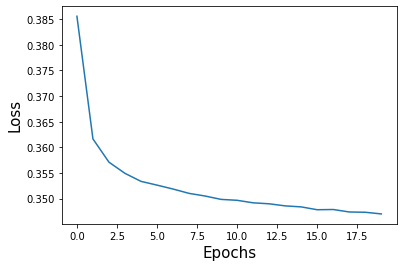

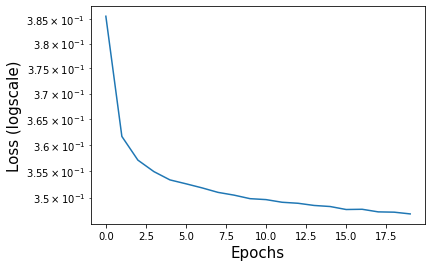

" plt.xlabel('Epochs',fontsize=15)\nplt.ylabel('Loss (logscale)',fontsize=15)\nplt.semilogy(running.history['val_loss'])\nplt.show() "

In [21]:
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.plot(running.history['loss'])
plt.show()
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Loss (logscale)',fontsize=15)
plt.semilogy(running.history['loss'])
plt.show()

""" plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Loss (logscale)',fontsize=15)
plt.semilogy(running.history['val_loss'])
plt.show() """

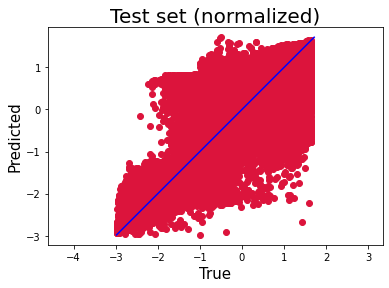

Normalized test MAE: 0.34778311186326194
Normalized test MSE: 0.29398583706741355
Normalized test MAPE: 70.6877452384493


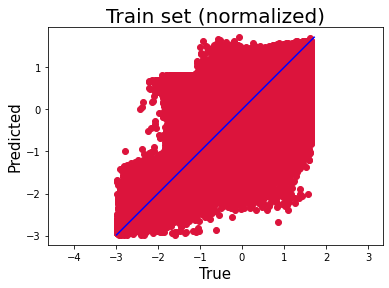

Normalized test MAE: 0.34658106654245524
Normalized test MSE: 0.29166211347312837
Normalized test MAPE: 69.9906094127178


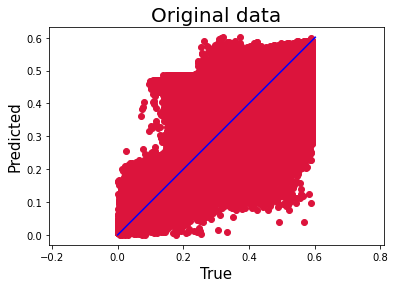

Test MAE: 0.04439817555073775
Test MSE: 0.004787290446457115
Test MAPE: 13.705190337281275


In [22]:
# Evaluate the model

# mean absolute percentage error (MAPE)
def mape(ytrue, ypred):
    ytrue, ypred = np.array(ytrue), np.array(ypred)
    
    mape_i = np.zeros(len(ytrue))
    mape_i = np.abs((ypred-ytrue)/ytrue)*100
    mape_i = mape_i[ mape_i < 1e3]

    return np.mean(mape_i)
    #return np.mean(np.abs((ytrue - ypred) / ytrue)) * 100

# Loss function on test set

y_exact = np.zeros(test_size)
y_pred = np.zeros(test_size)
y_exact[:] = YY_test[:,0]
y_pred[:] = Cp.eval([XX_test[:,0],XX_test[:,1]])

plt.figure()#figsize=(10,10))
plt.scatter(y_exact,y_pred,c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(y_pred), max(y_exact))
p2 = min(min(y_pred), min(y_exact))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True',fontsize=15)
plt.ylabel('Predicted',fontsize=15)
plt.axis('equal')
plt.title('Test set (normalized)',fontsize=20)
plt.show()

print("Normalized test MAE:", mean_absolute_error(y_exact,y_pred))
print("Normalized test MSE:", mean_squared_error(y_exact,y_pred))
print("Normalized test MAPE:", mape(y_exact,y_pred))

# Loss function on training set

y_exact = np.zeros(train_size)
y_pred = np.zeros(train_size)
y_exact[:] = YY_train[:,0]
y_pred[:] = Cp.eval([XX_train[:,0],XX_train[:,1]])

plt.figure()#figsize=(10,10))
plt.scatter(y_exact,y_pred,c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(y_pred), max(y_exact))
p2 = min(min(y_pred), min(y_exact))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True',fontsize=15)
plt.ylabel('Predicted',fontsize=15)
plt.axis('equal')
plt.title('Train set (normalized)',fontsize=20)
plt.show()

print("Normalized test MAE:", mean_absolute_error(y_exact,y_pred))
print("Normalized test MSE:", mean_squared_error(y_exact,y_pred))
print("Normalized test MAPE:", mape(y_exact,y_pred))

# Evaluation on the original dataset (without normalization)

y_exact = np.zeros(len(YY_data[:,0]))
y_pred = np.zeros(len(YY_data[:,0]))
y_exact[:] = YY_data[:,0] * Cp_std + Cp_avrg
y_pred[:] = Cp.eval([XX_data[:,0],XX_data[:,1]]) * Cp_std + Cp_avrg

plt.figure()#figsize=(10,10))
plt.scatter(y_exact,y_pred,c='crimson')
p1 = max(max(y_pred), max(y_exact))
p2 = min(min(y_pred), min(y_exact))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True',fontsize=15)
plt.ylabel('Predicted',fontsize=15)
plt.axis('equal')
plt.title('Original data',fontsize=20)
plt.show()


print("Test MAE:", mean_absolute_error(y_exact,y_pred))
print("Test MSE:", mean_squared_error(y_exact,y_pred))
print("Test MAPE:", mape(y_exact,y_pred))

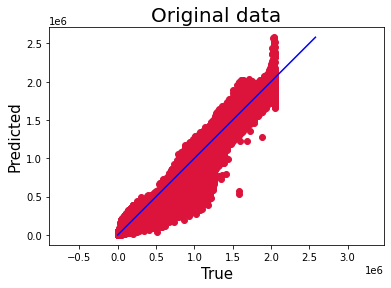

Test MAE: 47002.732857499956
Test MSE: 9338684292.33729
Test MAPE: 13.705190337281278


In [23]:
# Evaluate the model on the power prediction

# P
def P_fromCp(Cp, Vw):

    Pturbina = 0.5 * Cp * const.rho * const.A * Vw**3
    
    return Pturbina

# XX_data es lamba, que es adimensional
# V = WR / lambda
y_exact = np.zeros(len(YY_data[:,0]))
y_pred = np.zeros(len(YY_data[:,0]))
V_non_norm = np.zeros(len(YY_data[:,0]))
lambd_non_norm = np.zeros(len(YY_data[:,0]))

lambd_non_norm[:] = XX_data[:,0] * lambd_std + lambd_avrg
#V_non_norm[:] = (X_data[:,2] *x3_std + x3_avrg) * const.R/ lambd_non_norm[:]
V_non_norm[:] = X_data[:,0] *x1_std + x1_avrg

y_exact[:] = YY_data[:,0] * Cp_std + Cp_avrg
y_pred[:] = Cp.eval([XX_data[:,0],XX_data[:,1]]) * Cp_std + Cp_avrg
y_exact[:] = P_fromCp(y_exact[:],V_non_norm[:])
y_pred[:] = P_fromCp(y_pred[:],V_non_norm[:])


plt.figure()#figsize=(10,10))
plt.scatter(y_exact,y_pred,c='crimson')
p1 = max(max(y_pred), max(y_exact))
p2 = min(min(y_pred), min(y_exact))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True',fontsize=15)
plt.ylabel('Predicted',fontsize=15)
plt.axis('equal')
plt.title('Original data',fontsize=20)
plt.show()


print("Test MAE:", mean_absolute_error(y_exact,y_pred))
print("Test MSE:", mean_squared_error(y_exact,y_pred))
print("Test MAPE:", mape(y_exact,y_pred))

